In [1]:
import tensorflow
from PIL import Image
import glob
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img, save_img, img_to_array
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization,Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation,GlobalAveragePooling2D

from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau,EarlyStopping
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from sklearn.metrics import classification_report,accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import numpy as np
from tqdm import tqdm
import cv2
import os
import shutil
import itertools
import imutils
from sklearn.model_selection import StratifiedKFold
import random
from tensorflow.keras import layers
import tensorflow as tf


2025-08-06 16:11:24.188567: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754496684.387967      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754496684.445533      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
DATA_DIR = '/kaggle/input/brain-tumor-mri-dataset'


## Sample Images


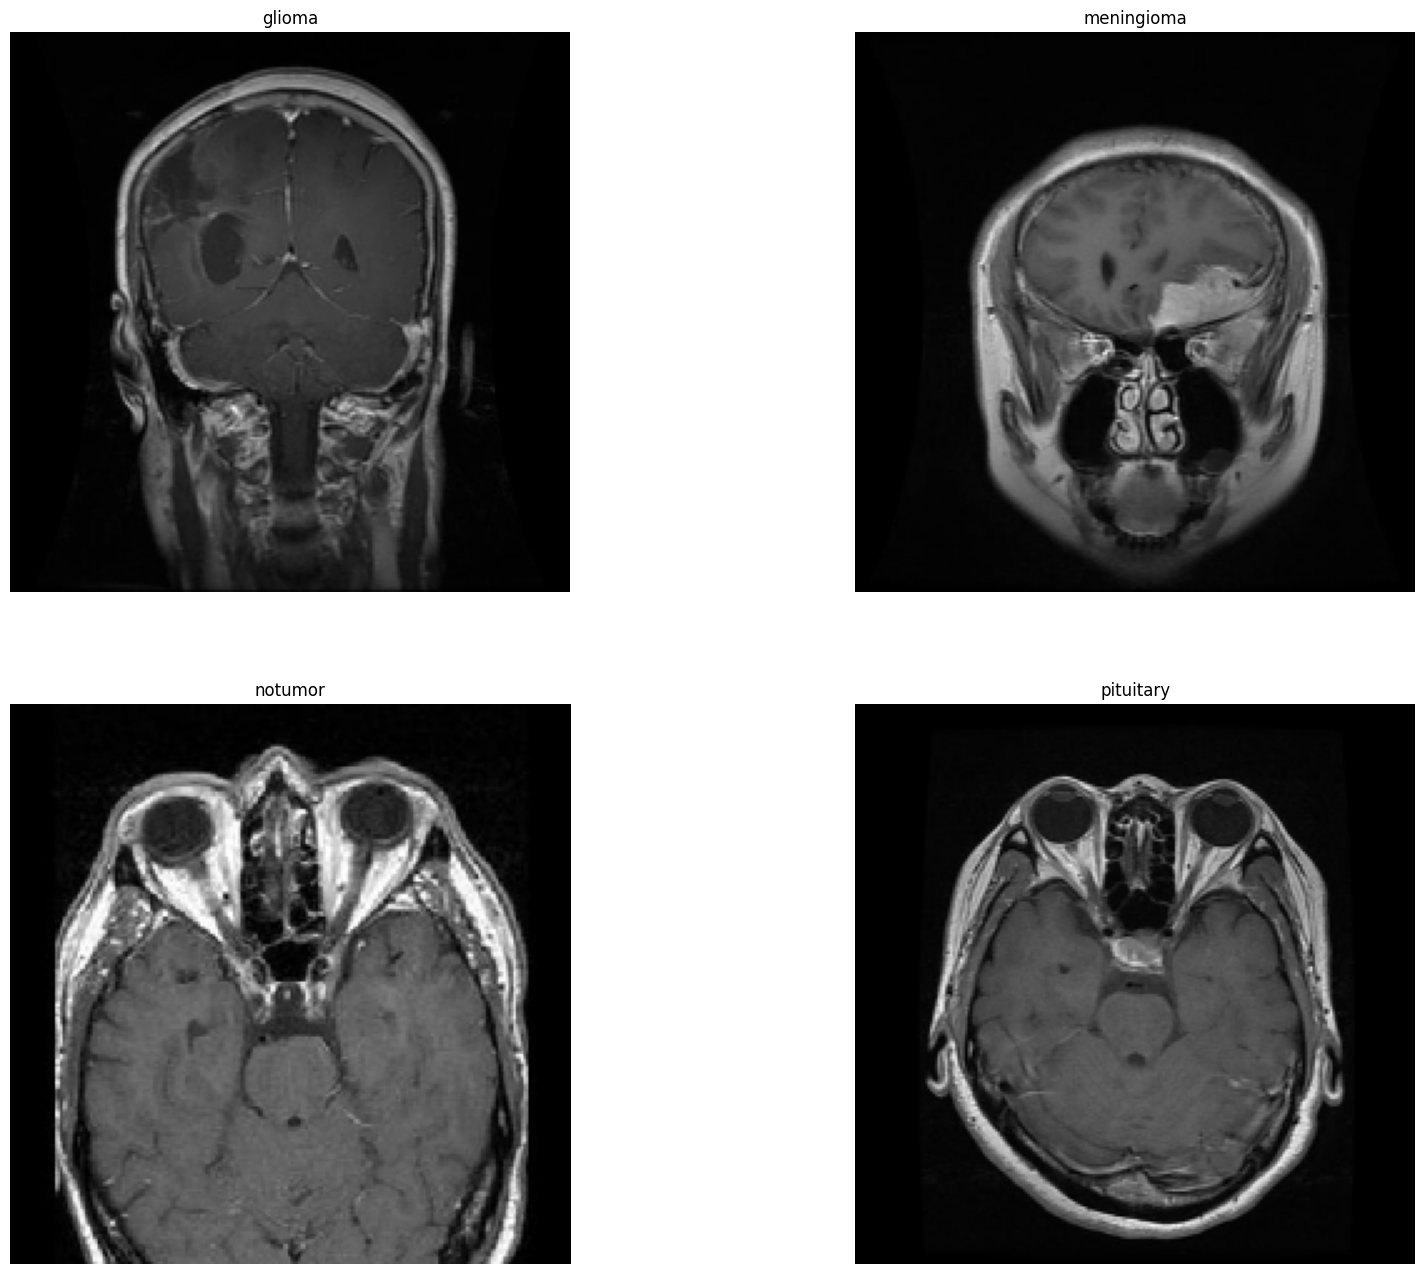

In [3]:


# Data Directory (Kaggle Path)
data_dir = '/kaggle/input/brain-tumor-mri-dataset/Training'
categories = ['glioma', 'meningioma', 'notumor', 'pituitary']

images_path = ['glioma/Tr-gl_0010.jpg', 
               'meningioma/Tr-meTr_0000.jpg', 
               'notumor/Tr-noTr_0000.jpg', 
               'pituitary/Tr-piTr_0000.jpg']

plt.figure(figsize=(20, 16))

for i in range(4):
    img_path = os.path.join(data_dir, images_path[i])
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for correct colors
    img = cv2.resize(img, (224, 224))
    
    ax = plt.subplot(2, 2, i + 1)
    plt.imshow(img)
    plt.title(categories[i])
    plt.axis('off')

plt.show()


In [4]:
def crop_img(img):
    """
    Finds the extreme points on the image and crops the rectangular out of them
    """
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray = cv2.GaussianBlur(gray, (3, 3), 0)

    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)

    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    ADD_PIXELS = 0
    new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
    
    return new_img


## 🔷 Tumor Region Extraction using Contour Detection & Cropping (Single Image Example)


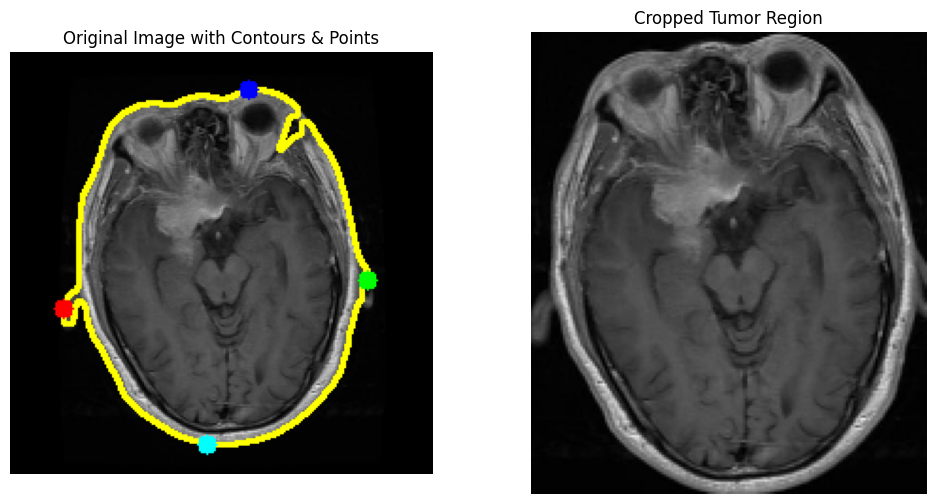

In [5]:

# Load Image
img_path = '/kaggle/input/brain-tumor-mri-dataset/Training/meningioma/Tr-meTr_0005.jpg'
img = cv2.imread(img_path)
img = cv2.resize(img, (224, 224), interpolation=cv2.INTER_CUBIC)

# Preprocess Image (Grayscale + Blur)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)

# Thresholding to Segment Tumor Region
thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
thresh = cv2.erode(thresh, None, iterations=2)
thresh = cv2.dilate(thresh, None, iterations=2)

# Find Contours (tumor region)
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
c = max(cnts, key=cv2.contourArea)

# Find Extreme Points (left, right, top, bottom)
extLeft = tuple(c[c[:, :, 0].argmin()][0])
extRight = tuple(c[c[:, :, 0].argmax()][0])
extTop = tuple(c[c[:, :, 1].argmin()][0])
extBot = tuple(c[c[:, :, 1].argmax()][0])

# Draw Contour & Extreme Points on Image
img_cnt = cv2.drawContours(img.copy(), [c], -1, (0, 255, 255), 2)
img_pnt = cv2.circle(img_cnt.copy(), extLeft, 5, (0, 0, 255), -1)
img_pnt = cv2.circle(img_pnt, extRight, 5, (0, 255, 0), -1)
img_pnt = cv2.circle(img_pnt, extTop, 5, (255, 0, 0), -1)
img_pnt = cv2.circle(img_pnt, extBot, 5, (255, 255, 0), -1)

# Crop Tumor Region using Extreme Points
ADD_PIXELS = 0
new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

# Plot Original + Contours vs Cropped Tumor
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img_pnt, cv2.COLOR_BGR2RGB))
plt.title("Original Image with Contours & Points")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(new_img, cv2.COLOR_BGR2RGB))
plt.title("Cropped Tumor Region")
plt.axis('off')

plt.show()


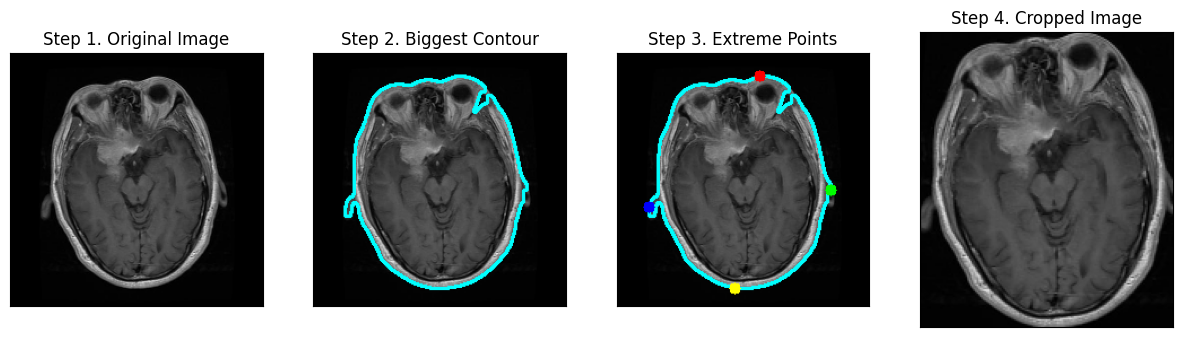

In [6]:
plt.figure(figsize=(15,6))
plt.subplot(141)
plt.imshow(img)
plt.xticks([]); plt.yticks([])
plt.title('Step 1. Original Image')

plt.subplot(142)
plt.imshow(img_cnt)
plt.xticks([]); plt.yticks([])
plt.title('Step 2. Biggest Contour')

plt.subplot(143)
plt.imshow(img_pnt)
plt.xticks([]); plt.yticks([])
plt.title('Step 3. Extreme Points')

plt.subplot(144)
plt.imshow(new_img)
plt.xticks([]); plt.yticks([])
plt.title('Step 4. Cropped Image')

plt.show()

##  Loading and Preprocessing Cropped Brain MRI Images (Training & Testing Sets)


In [7]:

labels = ['glioma', 'meningioma', 'notumor', 'pituitary']

x_train = []
y_train = []
x_test = []
y_test = []

image_size = 200

for label in labels:
    trainPath = os.path.join('/kaggle/input/brain-tumor-mri-dataset/Training', label)
    for file in tqdm(os.listdir(trainPath)):
        image = cv2.imread(os.path.join(trainPath, file), 0)  # Load grayscale image
        image = cv2.bilateralFilter(image, 2, 50, 50)
        image = cv2.applyColorMap(image, cv2.COLORMAP_BONE)
        image = cv2.resize(image, (image_size, image_size))
        x_train.append(image)
        y_train.append(labels.index(label))
    
    testPath = os.path.join('/kaggle/input/brain-tumor-mri-dataset/Testing', label)
    for file in tqdm(os.listdir(testPath)):
        image = cv2.imread(os.path.join(testPath, file), 0)
        image = cv2.bilateralFilter(image, 2, 50, 50)
        image = cv2.applyColorMap(image, cv2.COLORMAP_BONE)
        image = cv2.resize(image, (image_size, image_size))
        x_test.append(image)
        y_test.append(labels.index(label))

x_train = np.array(x_train) / 255.0
x_test = np.array(x_test) / 255.0

print(f"x_train shape: {x_train.shape}")
print(f"x_test shape: {x_test.shape}")


100%|██████████| 300/300 [00:02<00:00, 123.95it/s]


x_train shape: (5712, 200, 200, 3)
x_test shape: (1311, 200, 200, 3)


## Preparing Data: Shuffle, One-Hot Encoding, and Train-Validation Split


In [8]:
# Shuffle the training data
x_train, y_train = shuffle(x_train, y_train, random_state=42)

# One Hot Encoding on the labels
y_train = tf.keras.utils.to_categorical(y_train, num_classes=4)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=4)

# Splitting data into Training and Validation sets
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

# Check validation shape
print(x_val.shape)


(1143, 200, 200, 3)


## Image Augmentation


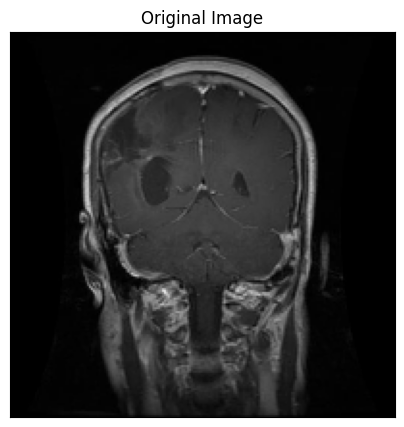

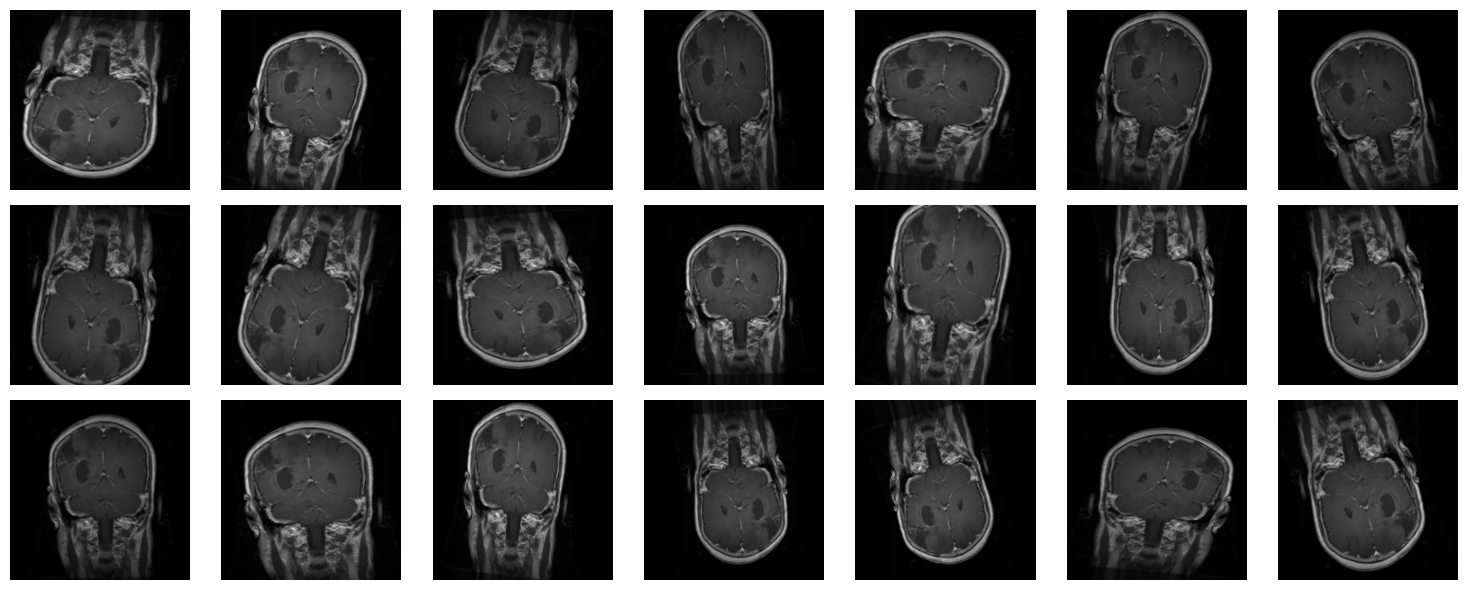

In [9]:

# Pick a sample image from Training (before normalization)
img = cv2.imread('/kaggle/input/brain-tumor-mri-dataset/Training/glioma/Tr-gl_0010.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (200, 200))  # Same as image_size

# Expand dims to make it batch of 1
x = np.expand_dims(img, axis=0)

# ImageDataGenerator with Rescale inside
demo_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.2,
    shear_range=0.05,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    vertical_flip=True,
    rescale=1./255   # Rescaling inside Generator
)
# Display Original Image
plt.figure(figsize=(5,5))
plt.imshow(x[0])
plt.xticks([])
plt.yticks([])
plt.title('Original Image')
plt.show()


# Plot
plt.figure(figsize=(15, 6))
i = 0
for batch in demo_datagen.flow(x, batch_size=1):
    plt.subplot(3, 7, i+1)
    plt.imshow(batch[0])
    plt.axis('off')
    i += 1
    if i >= 21:
        break
plt.tight_layout()
plt.show()


In [10]:
from tensorflow.keras.applications.resnet import ResNet50

# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=10,                        
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True
)

# Optional: If you’re doing normalization-based augmentations, otherwise not needed
# datagen.fit(x_train)

# Load ResNet50 Base Model
IMG_SIZE = (200, 200)
conv_base = ResNet50(
    include_top=False,
    input_shape=IMG_SIZE + (3,),
    weights='imagenet'
)

# Make all layers trainable (fine-tuning)
for layer in conv_base.layers:
    layer.trainable = True

# Building Custom Head on top of ResNet50
x = conv_base.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
output = Dense(4, activation="softmax")(x)

# Final Model
model = Model(inputs=conv_base.input, outputs=output)

# Compile Model
adam = Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

# Summary
model.summary()


I0000 00:00:1754496764.802821      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 200, 200,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 206, 206,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 100, 100,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 100, 100,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 100, 100,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 102, 102,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 50, 50,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 50, 50,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 50, 50,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 50, 50,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 50, 50,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 50, 50,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 50, 50,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 50, 50,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 50, 50,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 50, 50,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 50, 50,    │      1,024 │ conv2_block1_3_c

 Total params: 23,595,908 (90.01 MB)

 Trainable params: 23,542,788 (89.81 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [11]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard


# 1. Define Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)
checkpoint = ModelCheckpoint('best_classification_model.h5', monitor='val_loss', save_best_only=True, verbose=1)


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 3. Train Model
history = model.fit(
    datagen.flow(x_train, y_train, batch_size=32, shuffle=True),
    validation_data=(x_val, y_val),
    epochs=100,
    callbacks=[early_stop, reduce_lr, checkpoint],
    steps_per_epoch=len(x_train) // 32,
    verbose=1
)




/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100


I0000 00:00:1754496820.611416      64 service.cc:148] XLA service 0x794a6c002290 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1754496820.612274      64 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1754496825.109462      64 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/142 ━━━━━━━━━━━━━━━━━━━━ 2:47:24 71s/step - accuracy: 0.2188 - loss: 1.7878

I0000 00:00:1754496844.021797      64 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step - accuracy: 0.7509 - loss: 0.7537
Epoch 1: val_loss improved from inf to 2.24862, saving model to best_classification_model.h5
142/142 ━━━━━━━━━━━━━━━━━━━━ 136s 461ms/step - accuracy: 0.7514 - loss: 0.7519 - val_accuracy: 0.2283 - val_loss: 2.2486 - learning_rate: 0.0010
Epoch 2/100
  1/142 ━━━━━━━━━━━━━━━━━━━━ 20s 145ms/step - accuracy: 0.9688 - loss: 0.1160

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_loss improved from 2.24862 to 2.17810, saving model to best_classification_model.h5
142/142 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.9688 - loss: 0.1160 - val_accuracy: 0.2283 - val_loss: 2.1781 - learning_rate: 0.0010
Epoch 3/100
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - accuracy: 0.9308 - loss: 0.2110
Epoch 3: val_loss improved from 2.17810 to 1.76953, saving model to best_classification_model.h5
142/142 ━━━━━━━━━━━━━━━━━━━━ 38s 265ms/step - accuracy: 0.9308 - loss: 0.2110 - val_accuracy: 0.2765 - val_loss: 1.7695 - learning_rate: 0.0010
Epoch 4/100
  1/142 ━━━━━━━━━━━━━━━━━━━━ 19s 139ms/step - accuracy: 0.9688 - loss: 0.0933
Epoch 4: val_loss did not improve from 1.76953
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9688 - loss: 0.0933 - val_accuracy: 0.2765 - val_loss: 1.7949 - learning_rate: 0.0010
Epoch 5/100
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step - accuracy: 0.9373 - loss: 0.1972
Epoch 5: val_loss did not improve from 1.76953
142/142 ━━━━━━━

## Learning Curves


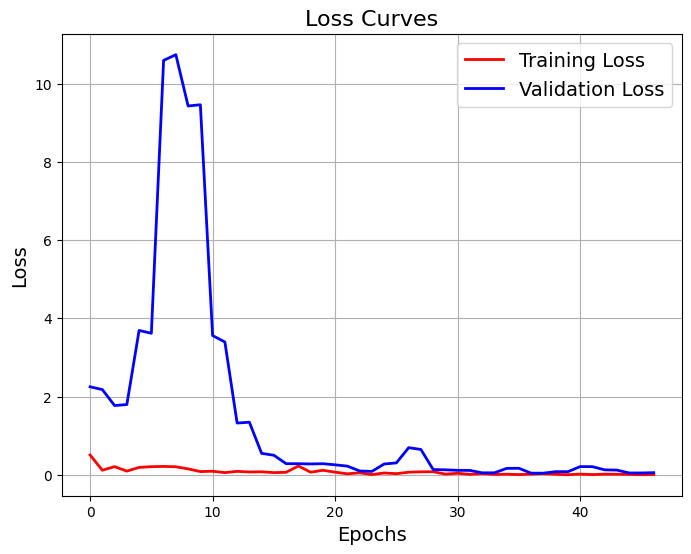

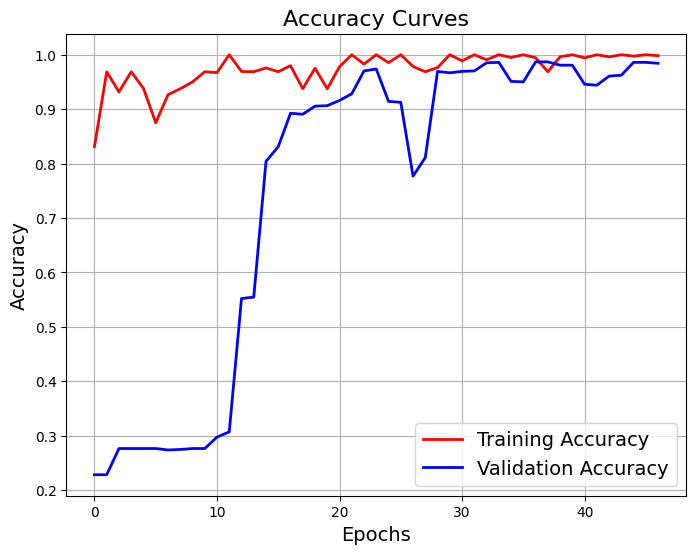

In [12]:
# Plot the Loss Curves
plt.figure(figsize=(8,6))
plt.plot(history.history['loss'], 'r', linewidth=2)
plt.plot(history.history['val_loss'], 'b', linewidth=2)
plt.legend(['Training Loss', 'Validation Loss'], fontsize=14)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title('Loss Curves', fontsize=16)
plt.grid(True)
plt.show()

# Plot the Accuracy Curves
plt.figure(figsize=(8,6))
plt.plot(history.history['accuracy'], 'r', linewidth=2)
plt.plot(history.history['val_accuracy'], 'b', linewidth=2)
plt.legend(['Training Accuracy', 'Validation Accuracy'], fontsize=14)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.title('Accuracy Curves', fontsize=16)
plt.grid(True)
plt.show()


## Validation on Test set


In [13]:
loss,acc = model.evaluate(x_test,y_test)


41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 111ms/step - accuracy: 0.9877 - loss: 0.0630


In [14]:
import seaborn as sns
predicted_classes = np.argmax(model.predict(x_test), axis = 1)
print(classification_report(np.argmax(y_test,axis=1), predicted_classes,target_names=['glioma','meningioma','no_tumor','pituitary']))
     

41/41 ━━━━━━━━━━━━━━━━━━━━ 10s 140ms/step
              precision    recall  f1-score   support

      glioma       1.00      0.98      0.99       300
  meningioma       0.97      1.00      0.99       306
    no_tumor       1.00      0.99      1.00       405
   pituitary       1.00      0.99      0.99       300

    accuracy                           0.99      1311
   macro avg       0.99      0.99      0.99      1311
weighted avg       0.99      0.99      0.99      1311



164/164 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step
164/164 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step


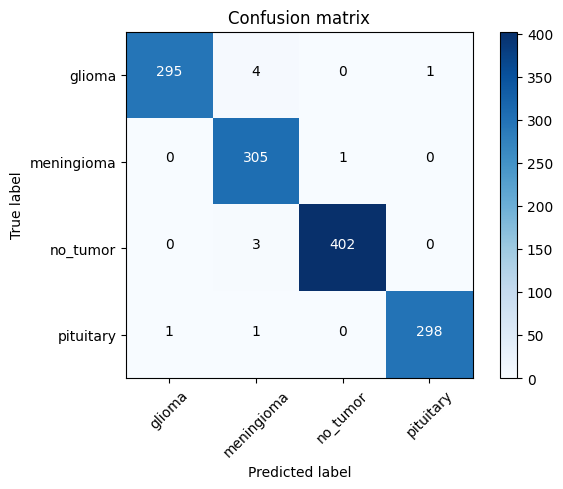

In [15]:
import itertools
pred_Y = model.predict(x_test, batch_size = 8, verbose = True)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    target_names=['glioma','meningioma','no_tumor','pituitary']

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(x_test, batch_size=8)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(pred_Y,axis = 1) 
# Convert validation observations to one hot vectors
# compute the confusion matrix
rounded_labels=np.argmax(y_test, axis=1)
confusion_mtx = confusion_matrix(rounded_labels, Y_pred_classes)

 

# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(4)) 

41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step


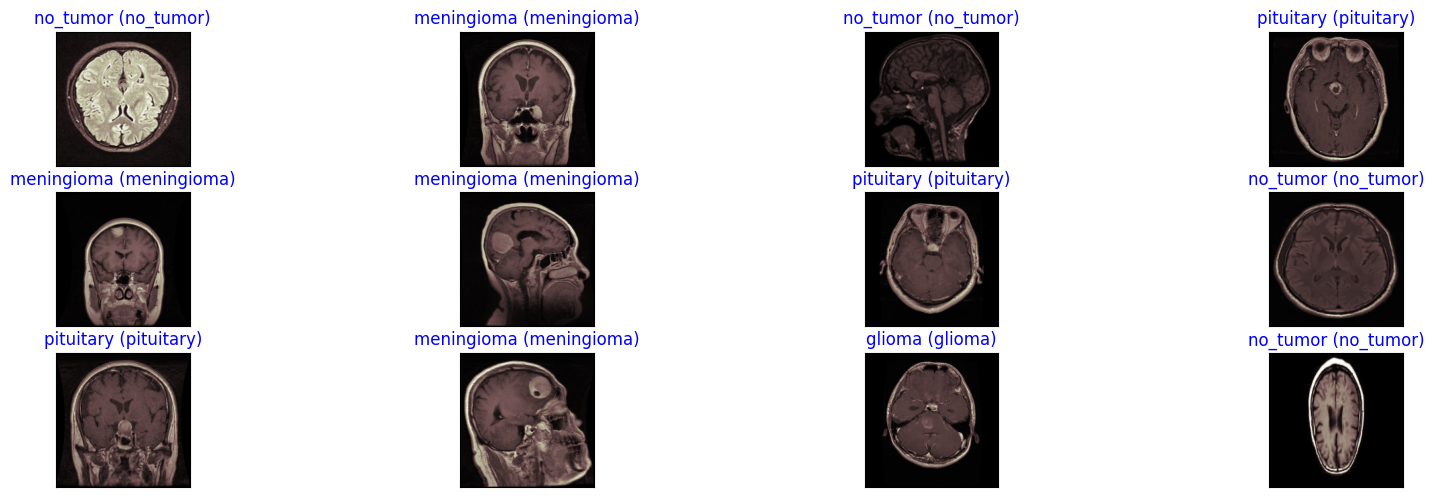

In [16]:

y_hat = model.predict(x_test)

# define text labels 
target_labels = ['glioma','meningioma','no_tumor','pituitary']

# plot a random sample of test images, their predicted labels, and ground truth
fig = plt.figure(figsize=(20, 8))
for i, idx in enumerate(np.random.choice(x_test.shape[0], size=12, replace=False)):
    ax = fig.add_subplot(4,4, i+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test[idx]))
    pred_idx = np.argmax(y_hat[idx])
    true_idx = np.argmax(y_test[idx])
    ax.set_title("{} ({})".format(target_labels[pred_idx], target_labels[true_idx]),
                 color=("blue" if pred_idx == true_idx else "orange"))

In [17]:
# Save model to HDF5 file
model.save('best_classification_model.h5')


In [18]:
from tensorflow.keras.models import load_model

model = load_model('best_classification_model.h5')
